In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

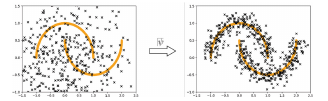

Fig.1 A schematic representation of generative modeling seen as mapping noise (left: black crosses) to data (right: black crosses around orange moons) using some transformation .ψ.

## Score-Based Generative Models

### Introduction

Let us start with the following quote from the abstract of [1]:

> "Creating noise from data is easy; creating data from noise is generative modeling."

I must say that it is hard to come up with a shorter definition of concurrent generative modeling. Once we look at various classes of models, we immediately notice that this is exactly what we try to do: generate data from noise! Don’t believe me? Ok, we should have a look at how various classes of generative models work:

- **GANs**: Sample noise $ z $ from a known distribution $ p(z) $ and use a generator $ G(z) $ to get data.
- **VAEs**: Sample noise $ z $ from a prior $ p(z) $ and use a decoder $ p(x|z) $ to sample data.
- **Normalizing flows**: Sample noise $ z $ from a base distribution $ p(z) $, and use an invertible transformation $ f $ to get data, $ x = f^{-1}(z) $.

I hope you see the pattern, my curious reader. In general, we can say that we look for a transformation $ \psi $ that maps noise $ z $ to data $ x $, namely, 

$$ x = \psi(z) $$

An example is presented in Fig. 9.1. In GANs, VAEs, and normalizing flows, the transformation is done in a “single step” by some neural net, namely, noise is mapped to data through a generator, a decoder, or an inversion of $ f $, respectively.

However, this does not need to be accomplished in this manner. In fact, we could easily think of an iterative process. And we know such a class of models already: **diffusion-based models**!

The **forward diffusion** adds Gaussian noise to a datapoint in the consecutive steps until the datapoint becomes pure Gaussian noise, i.e., $ x_0 \sim p_{\text{data}}(x) $ and $ x_1 \sim \mathcal{N}(0, I) $. (A notation reminder: a datapoint $ x \equiv x_0 $ and noise $ z \equiv x_1 $).

Then, the generative part (a.k.a. the **backward diffusion**) starts with $ x_1 $ (i.e., pure Gaussian noise) and removes a small amount of noise step by step until data $ x_0 $ is achieved.

In the first implementations of diffusion models [2, 3], a finite number of steps were used, $ T < +\infty $; thus, diffusion-based models could be seen as hierarchical VAEs with fixed encoders (see Chapter 5 and [4]).

### Fig.1

A schematic representation of generative modeling seen as mapping noise (left: black crosses) to data (right: black crosses around orange moons) using some transformation $ \psi $.

In practice, the success of diffusion-based models comes from their depth, among other aspects. In other words, we can learn extremely deep hierarchical models (e.g., $ T = 1000 $) because the generation process is defined as removing small bits of noise for two consecutive variables.

During training, a shared network is trained to predict this tiny-teeny amount of noise in a stochastic manner by sampling $ t \in [0, 1] $ and then optimizing the following loss:

$$
L_t(x_t) = \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[ \gamma_t \| \epsilon - \epsilon_{\theta}(x_t, t) \|^2 \right]
$$

where:
- $ \epsilon_t $ is a sample from the standard Gaussian,
- $ \gamma_t $ is a variance following the noise schedule,
- $ \epsilon_{\theta}(\cdot) $ is a shared neural net across all $ t $'s that aims at predicting $ \epsilon $ given $ x_t $ and $ t $,
- $ x_t $ could be expressed using the given data $ x_0 $ and $ \epsilon $.

For simplicity, $ \gamma_t $ is set to 1, which results in the so-called **simplified objective** [3], but it could also be learned [5].

### Continuous Diffusion Steps

I know you, my curious reader, and I see your question coming. Since diffusion models work so well because the number of steps $ T $ is large, why not go wild and take infinitely many steps, $ T = +\infty $?

It is a reasonable way of thinking; nonetheless, it entails some issues:
1. We would need to deal with continuous $ t \in [0, 1] $.
2. We actually know that we can use **differential equations** to take care of this issue.

But then a second issue arises: How to define generative models through differential equations? Ideally, we would like to obtain a method that allows us to train such models in a simple manner with a loss similar to $ (9.1) $.

It turns out that it is possible! But first, we will look into a different way of changing noise to data, a method called **score matching**. After that, we will be equipped with a learning strategy for dealing with continuous time (i.e., infinitely deep generative models). Eventually, we will discuss an alternative to score matching called **flow matching**.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Assuming a simple dataset for demonstration, e.g., MNIST
# You can replace this with any other dataset.
from torchvision import datasets, transforms

# Define the network that will predict the noise (ϵθ)
class NoisePredictor(nn.Module):
    def __init__(self):
        super(NoisePredictor, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 784)  # Output is same as input size (flattened image)

    def forward(self, x, t):
        # Simple feed-forward network predicting the noise
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Predicted noise

# Diffusion model implementation
class DiffusionModel:
    def __init__(self, model, beta_min=0.0001, beta_max=0.02, T=1000):
        self.model = model
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        
        # Linear schedule for betas (noise schedule)
        self.betas = torch.linspace(self.beta_min, self.beta_max, self.T)
        
        # Precompute the cumulative product of betas (used in forward and reverse process)
        self.alpha_bar = torch.cumprod(1.0 - self.betas, dim=0)
        
    def forward_diffusion(self, x0):
        """ Add noise to the data (forward diffusion process) """
        batch_size = x0.shape[0]
        t = torch.randint(0, self.T, (batch_size,), device=x0.device).long()  # Random time steps
        noise = torch.randn_like(x0)
        
        # Add noise scaled by sqrt(alpha_bar[t])
        x_t = torch.sqrt(self.alpha_bar[t].unsqueeze(1)) * x0 + torch.sqrt(1 - self.alpha_bar[t].unsqueeze(1)) * noise
        
        return x_t, noise, t
    
    def reverse_diffusion(self, x_t, t):
        """ Reverse the diffusion process (denoise the data) """
        # Use the model to predict the noise
        predicted_noise = self.model(x_t, t)
        
        # Retrieve the corresponding alpha_bar values
        alpha_bar_t = self.alpha_bar[t]
        
        # Backward diffusion step (reverse the noise)
        x_t_minus_1 = (x_t - torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_bar_t)
        
        return x_t_minus_1

# Loss function (simplified as per the given formula)
def loss_fn(predicted_noise, true_noise, t):
    return torch.mean((predicted_noise - true_noise) ** 2)

# Dataset and DataLoader (using MNIST here as an example)
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])  # Flatten images
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize model and optimizer
model = NoisePredictor().cuda()
diffusion_model = DiffusionModel(model).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x0, _) in enumerate(train_loader):
        x0 = x0.cuda()

        # Add noise using the forward diffusion process
        x_t, true_noise, t = diffusion_model.forward_diffusion(x0)
        
        # Forward pass: predict noise
        predicted_noise = model(x_t, t)
        
        # Compute loss
        loss = loss_fn(predicted_noise, true_noise, t)
        
        # Backpropagate and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(train_loader):.4f}")

# Generate samples (sampling from pure noise)
def generate_samples(diffusion_model, num_samples=10):
    diffusion_model.model.eval()
    with torch.no_grad():
        # Start with pure Gaussian noise (x_T)
        x_t = torch.randn(num_samples, 784).cuda()
        t = torch.full((num_samples,), diffusion_model.T - 1, dtype=torch.long, device=x_t.device)
        
        # Reverse diffusion process
        for step in range(diffusion_model.T - 1, -1, -1):
            x_t = diffusion_model.reverse_diffusion(x_t, t)
            t = torch.maximum(t - 1, torch.zeros_like(t))  # Decrease t
        
        # Reshape and convert to image format (28x28)
        generated_images = x_t.view(num_samples, 28, 28).cpu().numpy()
        
        # Display generated images
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
        plt.show()

# Sample from the trained model
generate_samples(diffusion_model)


Epoch [1/5], Loss: 41.4187
Epoch [2/5], Loss: 41.5620
Epoch [3/5], Loss: 43.8296
Epoch [4/5], Loss: 41.8092
Epoch [5/5], Loss: 33.7924


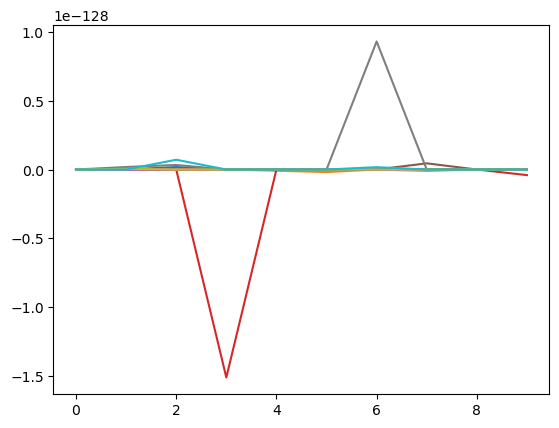

In [3]:
import random
import math
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
random.seed(42)

# Simple class to simulate a noise predictor (basic version)
class NoisePredictor:
    def __init__(self):
        pass
    
    def predict_noise(self, x_t, t):
        # Simple linear noise prediction based on time step `t`
        # This is just a mock-up function for the sake of simplicity
        return [0.5 * random.random() * value for value in x_t]

# Simple Diffusion Model
class DiffusionModel:
    def __init__(self, beta_min=0.0001, beta_max=0.02, T=1000):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        
        # Linear schedule for betas (noise schedule)
        self.betas = [beta_min + (beta_max - beta_min) * (i / T) for i in range(T)]
        
        # Precompute the cumulative product of betas (used in forward and reverse process)
        self.alpha_bar = []
        alpha = 1.0
        for i in range(T):
            alpha *= (1 - self.betas[i])
            self.alpha_bar.append(alpha)
        
    def forward_diffusion(self, x0):
        """ Add noise to the data (forward diffusion process) """
        batch_size = len(x0)
        t = random.randint(0, self.T - 1)  # Random time step
        
        noise = [random.gauss(0, 1) for _ in range(batch_size)]  # Gaussian noise
        x_t = [self.alpha_bar[t] * x0[i] + math.sqrt(1 - self.alpha_bar[t]) * noise[i] for i in range(batch_size)]
        
        return x_t, noise, t
    
    def reverse_diffusion(self, x_t, t, predictor):
        """ Reverse the diffusion process (denoise the data) """
        # Use the model to predict the noise
        predicted_noise = predictor.predict_noise(x_t, t)
        
        # Backward diffusion step (reverse the noise)
        x_t_minus_1 = [x_t[i] - predicted_noise[i] for i in range(len(x_t))]
        
        return x_t_minus_1

# Loss function (simplified)
def loss_fn(predicted_noise, true_noise):
    return sum((predicted_noise[i] - true_noise[i]) ** 2 for i in range(len(predicted_noise)))

# Simple mock data (as a list of values)
def generate_mock_data(batch_size=64):
    return [random.random() for _ in range(batch_size)]

# Initialize the Diffusion model and Noise Predictor
model = NoisePredictor()
diffusion_model = DiffusionModel()

# Training loop (simplified)
num_epochs = 5
batch_size = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for _ in range(batch_size):
        # Generate random data point (mock data)
        x0 = generate_mock_data()
        
        # Forward diffusion process: Add noise
        x_t, true_noise, t = diffusion_model.forward_diffusion(x0)
        
        # Predict the noise using the simple model
        predicted_noise = model.predict_noise(x_t, t)
        
        # Compute the loss
        loss = loss_fn(predicted_noise, true_noise)
        
        # Running total loss (for simplicity, we're not using backpropagation)
        running_loss += loss
    
    # Print loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / batch_size:.4f}")

# Generate samples (start from noise and reverse the diffusion)
def generate_samples(diffusion_model, num_samples=10):
    generated_samples = []
    
    for _ in range(num_samples):
        # Start with pure Gaussian noise (x_T)
        x_t = [random.gauss(0, 1) for _ in range(batch_size)]
        
        # Reverse the diffusion process
        for t in range(diffusion_model.T - 1, -1, -1):
            x_t = diffusion_model.reverse_diffusion(x_t, t, model)
        
        generated_samples.append(x_t)
    
    return generated_samples

# Sample generation
generated_samples = generate_samples(diffusion_model)

# Display generated samples (simple 1D visualization)
for sample in generated_samples:
    plt.plot(sample)
plt.show()


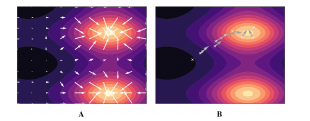

Fig.2 (a) An illustration of the score function .s(x) plotted as vectors (white arrows) on a regular grid for a multimodal distribution (dark colors correspond to low probability; bright colors depict high probability). (b) A trajectory after applying the SGLD (consecutive points are represented by white crosses, and their scores are denoted by gray arrows).

# Score Matching: Modeling and the Objective

The goal is to create a model that turns noise into data in an iterative manner. To begin with, we assume the following:

- We have access to the real distribution $ p_{\text{real}}(x) $, where $ x \in X $.
- We randomly sample a point $ \hat{x} \in X $ from the data space. However, it is highly likely that $ p_{\text{real}}(\hat{x}) \approx 0 $.
- The challenge is: How do we turn $ \hat{x} $ into a valid datapoint, i.e., an object that can be observed in the real world?

### Stochastic Gradient Langevin Dynamics (SGLD)

A relatively fast and theoretically grounded method for sampling from $ p_{\text{real}}(x) $ is **Stochastic Gradient Langevin Dynamics (SGLD)**, which is also known as Langevin dynamics. The procedure starts at $ x_0 \equiv \hat{x} $ and evolves according to:

$$
x_{t+\Delta} = x_t + \alpha \nabla_x \ln p_{\text{real}}(x) + \eta \cdot \epsilon,
$$

where:

- $ \Delta $ is an increment,
- $ \alpha > 0 $ is the learning rate,
- $ \eta > 0 $ is the noise coefficient,
- $ \epsilon \sim \mathcal{N}(0, I) $ is Gaussian noise.

Eventually, this method converges to a point $ x_0 $ such that $ p_{\text{real}}(x_0) > 0 $, close to a mode of the distribution.

### The Challenge: Gradient of the Log Real Distribution

The issue with SGLD is that we do not have access to $ p_{\text{real}}(x) $, but we do have access to its gradient — the **score function**:

$$
s(x) = \nabla_x \ln p_{\text{real}}(x).
$$

If we can estimate the score function $ s(x) $, we can still run Langevin dynamics to sample points from the distribution. This leads to the idea of **score matching**: Instead of modeling the distribution directly, we model the score function.

### Objective for Score Matching

To optimize for the score function, we aim to minimize the following objective:

$$
J(\theta) = \frac{1}{2} \mathbb{E}_{p_{\text{data}}(x)} \left[ \| s_{\theta}(x) - \nabla_x \ln p_{\text{data}}(x) \|^2 \right],
$$

where $ s_{\theta}(x) $ is the predicted score function and $ \nabla_x \ln p_{\text{data}}(x) $ is the true score, which can be difficult to calculate directly.

### Non-Differentiability of $ p_{\text{data}}(x) $

Since $ p_{\text{data}}(x) $ is a discrete distribution given by:

$$
p_{\text{data}}(x) = \frac{1}{N} \sum_{n=1}^{N} \delta(x - x_n),
$$

where $ \delta(\cdot) $ is Dirac's delta function, this is non-differentiable. To solve this, we add some small Gaussian noise $ \sigma^2 $ to the data, resulting in a smoothed distribution:

$$
q_{\text{data}}(x_n) = \mathcal{N}(x_n | x_n, \sigma^2),
$$

which is a mixture of Gaussians centered around the data points.

### Modified Objective: Denoising Score Matching

With the noisy version of the data, we can now compute a differentiable objective:

$$
L(\theta) = \frac{1}{2N} \sum_{n=1}^{N} \mathbb{E}_{\mathcal{N}(\epsilon | 0, \sigma^2 I)} \left[ \| s_{\theta}(x_n + \sigma \epsilon) + \epsilon \|^2 \right],
$$

where $ \epsilon \sim \mathcal{N}(0, I) $. This is the **denoising score matching** objective, and it allows us to learn the score function without directly modeling the distribution.

### Derivation of the Score Function for Gaussian Distribution

For a Gaussian distribution $ \mathcal{N}(x_n | x_n, \sigma^2) $, the score function is known and can be derived as follows:

$$
\nabla_{x_n} \ln \mathcal{N}(x_n | x_n, \sigma^2) = -\frac{\epsilon}{\sigma^2},
$$

where $ x_n + \sigma \epsilon $ is the noisy version of the data. Substituting this into the objective function, we get:

$$
L(\theta) = \frac{1}{2N} \sum_{n=1}^{N} \mathbb{E}_{\mathcal{N}(\epsilon | 0, \sigma^2 I)} \left[ \| -\frac{\epsilon}{\sigma^2} + \epsilon \|^2 \right].
$$

### Final Objective Function for Score Matching

The final objective function for score matching is:

$$
L(\theta) = \mathbb{E}_{\mathcal{N}(\epsilon | 0, I)} \left[ \| \epsilon - \hat{s}_{\theta}(x_n + \sigma \epsilon) \|^2 \right],
$$

where $ \hat{s}_{\theta}(x) $ is the model’s predicted score function. The key idea here is that instead of learning the distribution $ p_{\text{real}}(x) $, we directly learn the score function, which can be used to generate samples from noise via Langevin dynamics.

### Conclusion

Score matching allows us to generate data from noise by optimizing the score function using a regression problem. This approach is an alternative to conventional generative models like GANs or VAEs and provides a novel perspective on learning generative models.



Epoch 1/200, Loss: 106.7902
Epoch 2/200, Loss: 161.7204
Epoch 3/200, Loss: 103.7392
Epoch 4/200, Loss: 99.0486
Epoch 5/200, Loss: 99.5153
Epoch 6/200, Loss: 97.3015
Epoch 7/200, Loss: 102.5875
Epoch 8/200, Loss: 97.6902
Epoch 9/200, Loss: 98.9711
Epoch 10/200, Loss: 99.7532
Epoch 11/200, Loss: 96.4543
Epoch 12/200, Loss: 97.9871
Epoch 13/200, Loss: 99.7506
Epoch 14/200, Loss: 99.2145
Epoch 15/200, Loss: 98.4235
Epoch 16/200, Loss: 96.8894
Epoch 17/200, Loss: 99.8470
Epoch 18/200, Loss: 98.4101
Epoch 19/200, Loss: 98.7430
Epoch 20/200, Loss: 97.7110
Epoch 21/200, Loss: 102.0936
Epoch 22/200, Loss: 97.1146
Epoch 23/200, Loss: 101.9711
Epoch 24/200, Loss: 100.7356
Epoch 25/200, Loss: 99.4592
Epoch 26/200, Loss: 98.6242
Epoch 27/200, Loss: 100.0109
Epoch 28/200, Loss: 98.3019
Epoch 29/200, Loss: 100.1461
Epoch 30/200, Loss: 96.6833
Epoch 31/200, Loss: 101.1413
Epoch 32/200, Loss: 100.2823
Epoch 33/200, Loss: 101.6334
Epoch 34/200, Loss: 99.5204
Epoch 35/200, Loss: 101.5375
Epoch 36/200, Lo

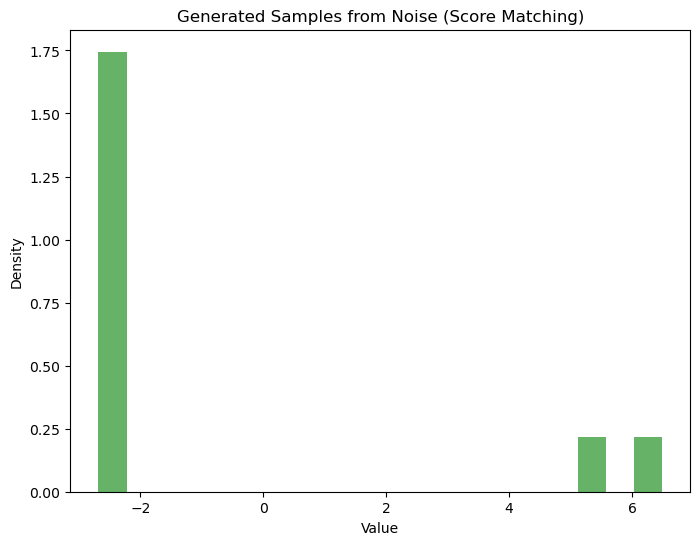

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Simulate data (e.g., Gaussian distribution as a simple example)
def generate_data(batch_size=64, mean=0, std=1):
    return np.random.normal(mean, std, batch_size)

# Score function model (simple neural network-like structure)
class ScoreFunctionModel:
    def __init__(self, input_dim=1, hidden_dim=10):
        # Initialize weights for a simple neural network (for the score function)
        self.w1 = np.random.randn(input_dim, hidden_dim)
        self.b1 = np.zeros(hidden_dim)
        self.w2 = np.random.randn(hidden_dim, input_dim)
        self.b2 = np.zeros(input_dim)

    def forward(self, x):
        # Simple 2-layer neural network
        z1 = np.dot(x, self.w1) + self.b1
        a1 = np.tanh(z1)  # Activation function (tanh)
        z2 = np.dot(a1, self.w2) + self.b2
        return z2  # This is the predicted score

# Loss function: Denoising Score Matching (MSE between true noise and predicted noise)
def denoising_score_matching_loss(model, x, sigma=0.1):
    epsilon = np.random.normal(0, 1, x.shape)  # Gaussian noise
    x_noisy = x + sigma * epsilon  # Noisy data

    # Compute the score predicted by the model
    s_pred = model.forward(x_noisy)
    
    # The true score is just the noise epsilon scaled by sigma
    s_true = -epsilon / sigma
    
    # Compute the loss as the squared error between predicted score and true score
    loss = np.mean(np.square(s_pred - s_true))
    return loss

# Gradient of the loss function (manual gradient calculation)
def compute_gradients(model, x, sigma=0.1, learning_rate=1e-3):
    epsilon = np.random.normal(0, 1, x.shape)
    x_noisy = x + sigma * epsilon

    # Compute the predicted score from the model
    s_pred = model.forward(x_noisy)
    
    # The true score
    s_true = -epsilon / sigma
    
    # Compute the gradient of the loss with respect to the model's parameters
    grad_w1 = np.dot(x_noisy.T, 2 * (s_pred - s_true) * (1 - np.tanh(np.dot(x_noisy, model.w1)) ** 2))  # Backprop through tanh
    grad_b1 = np.sum(2 * (s_pred - s_true) * (1 - np.tanh(np.dot(x_noisy, model.w1)) ** 2), axis=0)
    grad_w2 = np.dot(np.tanh(np.dot(x_noisy, model.w1)).T, 2 * (s_pred - s_true))
    grad_b2 = np.sum(2 * (s_pred - s_true), axis=0)
    
    # Update parameters (gradient descent)
    model.w1 -= learning_rate * grad_w1
    model.b1 -= learning_rate * grad_b1
    model.w2 -= learning_rate * grad_w2
    model.b2 -= learning_rate * grad_b2

# Training loop
def train_score_matching(model, data, num_epochs=100, batch_size=64, sigma=0.1, learning_rate=1e-3):
    for epoch in range(num_epochs):
        total_loss = 0
        
        for _ in range(batch_size):
            # Generate a random batch of data
            x = generate_data(batch_size)
            x = x.reshape(-1, 1)  # Reshaping to a column vector

            # Compute the loss and update the model
            loss = denoising_score_matching_loss(model, x, sigma)
            total_loss += loss
            
            # Compute gradients and update model parameters
            compute_gradients(model, x, sigma, learning_rate)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / batch_size:.4f}')

# Test the model after training (generating new data points from noise)
def generate_samples(model, num_samples=10, sigma=0.1):
    samples = []
    for _ in range(num_samples):
        # Start with pure noise
        x_t = np.random.normal(0, 1, (1, 1))  # Start with noise
        for t in range(100):  # Run the reverse diffusion process
            s_pred = model.forward(x_t)  # Predicted score (gradient)
            x_t = x_t - sigma * s_pred  # Update the point using the score
        samples.append(x_t[0][0])  # Append the sample to the list
    return np.array(samples)

# Initialize the model
model = ScoreFunctionModel(input_dim=1, hidden_dim=10)

# Train the model
train_score_matching(model, generate_data(batch_size=64), num_epochs=200, batch_size=64)

# Generate samples
generated_samples = generate_samples(model, num_samples=10)

# Plot the generated samples
plt.figure(figsize=(8, 6))
plt.hist(generated_samples, bins=20, density=True, alpha=0.6, color='g')
plt.title('Generated Samples from Noise (Score Matching)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


Epoch 1/100, Loss: 99.6867
Epoch 2/100, Loss: 402.9957
Epoch 3/100, Loss: 991.6408
Epoch 4/100, Loss: 1340.1075
Epoch 5/100, Loss: 1961.9267
Epoch 6/100, Loss: 2689.3672
Epoch 7/100, Loss: 3496.5987
Epoch 8/100, Loss: 3928.9537
Epoch 9/100, Loss: 3941.2360
Epoch 10/100, Loss: 5560.2440
Epoch 11/100, Loss: 7297.8204
Epoch 12/100, Loss: 10062.3586
Epoch 13/100, Loss: 8360.0519
Epoch 14/100, Loss: 6137.6245
Epoch 15/100, Loss: 5576.1938
Epoch 16/100, Loss: 11430.3858
Epoch 17/100, Loss: 9304.3379
Epoch 18/100, Loss: 9945.5468
Epoch 19/100, Loss: 7126.6299
Epoch 20/100, Loss: 6239.0016
Epoch 21/100, Loss: 5561.1936
Epoch 22/100, Loss: 8227.8390
Epoch 23/100, Loss: 8480.0629
Epoch 24/100, Loss: 4309.3906
Epoch 25/100, Loss: 10047.4619
Epoch 26/100, Loss: 12343.7603
Epoch 27/100, Loss: 8885.3310
Epoch 28/100, Loss: 10721.1639
Epoch 29/100, Loss: 12961.2861
Epoch 30/100, Loss: 7472.6963
Epoch 31/100, Loss: 8036.7537
Epoch 32/100, Loss: 9624.3123
Epoch 33/100, Loss: 19937.9341
Epoch 34/100, Lo

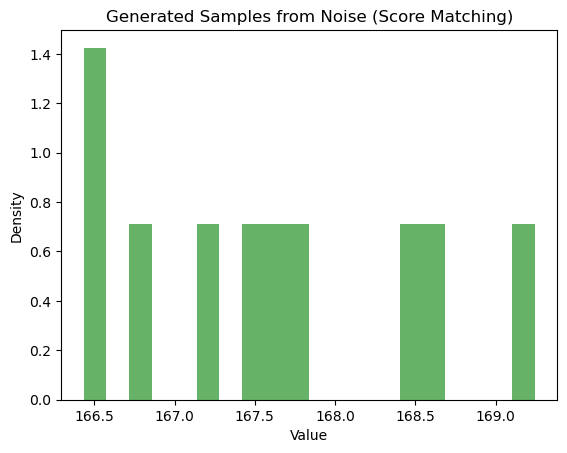

In [9]:
import random
import math

# Seed for reproducibility
random.seed(42)

# 1. Simulate data
def generate_data(batch_size=64, mean=0, std=1):
    """Generate random data using Gaussian distribution."""
    return [random.gauss(mean, std) for _ in range(batch_size)]

# 2. Define a simple score function model (manual implementation of a neural network-like structure)
class ScoreFunctionModel:
    def __init__(self, input_dim=1, hidden_dim=10):
        # Initialize parameters (weights and biases) for a very simple "neural network"
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.w1 = [[random.gauss(0, 1) for _ in range(hidden_dim)] for _ in range(input_dim)]  # Weights for layer 1 (input_dim x hidden_dim)
        self.b1 = [0 for _ in range(hidden_dim)]  # Biases for layer 1
        self.w2 = [random.gauss(0, 1) for _ in range(hidden_dim)]  # Weights for layer 2 (hidden_dim x 1)
        self.b2 = [0]  # Bias for output layer (scalar output)
    
    def forward(self, x):
        """Simple forward pass through the 'network'."""
        # Hidden layer (x is of shape (batch_size, input_dim))
        z1 = [sum([x[i] * self.w1[i][j] for i in range(self.input_dim)]) + self.b1[j] for j in range(self.hidden_dim)]
        a1 = [math.tanh(z) for z in z1]  # Activation function (tanh)

        # Output layer
        z2 = sum([a1[j] * self.w2[j] for j in range(self.hidden_dim)]) + self.b2[0]
        return z2  # This is the predicted score function value
    
# 3. Define the denoising score matching loss
def denoising_score_matching_loss(model, x, sigma=0.1):
    """Compute denoising score matching loss."""
    # Generate noise
    epsilon = [random.gauss(0, 1) for _ in x]  # Gaussian noise
    
    # Noisy data
    x_noisy = [x[i] + sigma * epsilon[i] for i in range(len(x))]

    # Compute model's predicted score
    s_pred = model.forward(x_noisy)
    
    # True score is the negative of the noise scaled by sigma
    s_true = -epsilon[0] / sigma  # Since the model outputs a scalar, we use the first element
    
    # Loss is the squared error between predicted and true score
    loss = (s_pred - s_true) ** 2
    return loss

# 4. Gradient computation (manual approach)
# 4. Gradient computation (manual approach)
def compute_gradients(model, x, sigma=0.1, learning_rate=1e-3):
    """Compute gradients of the loss with respect to the model parameters."""
    # Generate noise
    epsilon = [random.gauss(0, 1) for _ in x]
    
    # Noisy data
    x_noisy = [x[i] + sigma * epsilon[i] for i in range(len(x))]
    
    # Compute the predicted score
    s_pred = model.forward(x_noisy)
    
    # True score
    s_true = -epsilon[0] / sigma
    
    # Gradient of the loss w.r.t model parameters (simplified for scalar outputs)
    grad_w2 = 2 * (s_pred - s_true) * epsilon[0]
    grad_b2 = 2 * (s_pred - s_true)
    
    # Update w1
    grad_w1 = [[2 * (s_pred - s_true) * epsilon[0] * x_noisy[0] for _ in range(len(model.w1[0]))]]  # Gradients for w1 (corrected)
    grad_b1 = [2 * (s_pred - s_true) * epsilon[0] for _ in range(len(model.b1))]  # Gradients for b1

    # Update the model parameters using the gradients
    # Update w2
    model.w2 = [w - learning_rate * grad_w2 for w in model.w2]
    model.b2[0] -= learning_rate * grad_b2

    # Update w1
    for i in range(len(model.w1)):
        for j in range(len(model.w1[i])):
            model.w1[i][j] -= learning_rate * grad_w1[0][j]  # Corrected indexing for w1
    
    # Update b1
    for i in range(len(model.b1)):
        model.b1[i] -= learning_rate * grad_b1[i]



# 5. Training loop (simplified version)
def train_score_matching(model, num_epochs=100, batch_size=64, sigma=0.1, learning_rate=1e-3):
    """Training loop for denoising score matching."""
    for epoch in range(num_epochs):
        total_loss = 0
        for _ in range(batch_size):
            # Generate a random batch of data
            x = generate_data(batch_size=1)  # Single data point per batch
            
            # Compute the loss and update the model
            loss = denoising_score_matching_loss(model, x, sigma)
            total_loss += loss
            
            # Compute gradients and update model parameters
            compute_gradients(model, x, sigma, learning_rate)
        
        # Print loss for each epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / batch_size:.4f}')

# 6. Generate new samples (from learned score function)
def generate_samples(model, num_samples=10, sigma=0.1):
    """Generate samples starting from pure noise and applying Langevin dynamics."""
    samples = []
    for _ in range(num_samples):
        # Start with pure noise (a random value)
        x_t = [random.gauss(0, 1)]  # Single data point

        # Run the reverse diffusion process (Langevin dynamics)
        for t in range(100):  # Run for 100 steps
            s_pred = model.forward(x_t)  # Predicted score
            # Update the sample using the score
            x_t = [x_t[0] - sigma * s_pred]  # Langevin update
        samples.append(x_t[0])  # Store the sample
    
    return samples

# Initialize the model
model = ScoreFunctionModel(input_dim=1, hidden_dim=10)

# Train the model
train_score_matching(model, num_epochs=100, batch_size=64)

# Generate samples
generated_samples = generate_samples(model, num_samples=10)

# Print the generated samples
print("Generated Samples:", generated_samples)

# Optionally, visualize the results (using matplotlib for simple plots)
import matplotlib.pyplot as plt

plt.hist(generated_samples, bins=20, density=True, alpha=0.6, color='g')
plt.title('Generated Samples from Noise (Score Matching)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


## Training and Sampling for Score Matching (SM)

###  Training for Score Matching (SM)

To learn the score model, we repeat the following steps:

1. **Pick a data point** $ x $.
2. **Sample** $ \epsilon $ from $ \mathcal{N}(\epsilon | 0, I) $.
3. **Calculate the noisy version of the data**:
   $$
   \tilde{x} = x + \sigma \cdot \epsilon
   $$
4. **Calculate the score** $ \tilde{s}_\theta(\tilde{x}) $.
5. **Calculate the gradient with respect to** $ \theta $ of the score matching objective:
   $$
   \frac{1}{2} \Delta \theta = \nabla_\theta \frac{1}{2 \sigma} \left\| \epsilon - \tilde{s}_\theta(\tilde{x}) \right\|
   $$
   This is accomplished by applying automatic differentiation.
6. **Update the score model**:
   $$
   \theta := \theta - \Delta \theta
   $$

Repeat steps 1 through 6 until convergence. In practice, we use mini-batches, but the procedure remains the same.

### Sampling (Generation) for Score Matching (SM)

Once we learn the score model, we can use it for sampling using Langevin dynamics. The generative procedure is the following:

1. **Sample a point** $ x_0 $ at random (e.g., using a uniform distribution).
2. **Run Langevin dynamics for** $ T $ steps:
   $$
   x_{t+1} = x_t + \alpha \cdot \tilde{s}_\theta(x_t) + \eta \cdot \epsilon
   $$
   where $ \alpha $ is the step size, $ \tilde{s}_\theta(x_t) $ is the score predicted by the model, and $ \eta \cdot \epsilon $ represents the noise term.
3. **Return the final point** $ x_1 $.

Note that, to keep the formulation of Langevin dynamics unchanged, we use $ s_\theta(x_t) $ instead of $ \tilde{s}_\theta(x_t) $. This is possible because we know the relation:
$$
s_\theta(x_t) = -\frac{\tilde{s}_\theta(x_t)}{\sigma}
$$

###  Score Matching and Diffusion-Based Models

You may have noticed that the objective for diffusion-based models in Equation (9.3) and the score models in Equation (9.13) are almost identical, especially if we set $ \gamma_t = \frac{1}{\sigma} $! In fact, we can turn score matching into a diffusion-based approach with the following steps:

1. **Introduce a schedule for variances** $ \sigma_t^2 $, for $ t \in T $, where $ T = \{t: t \text{ goes from 0 to 1 with an increment} \Delta = \} $.
2. **Modify the score model** to be "aware" of this schedule:
   $$
   \tilde{s}_\theta(x, \sigma_t^2)
   $$
3. **Modify the objective** to incorporate the schedule:
   $$
   L(\theta) = \frac{1}{2N} \sum_{n=1}^N \sum_{t \in T} \frac{1}{\sigma_t} \left\| \epsilon - \tilde{s}_\theta(\tilde{x}, \sigma_t) \right\|^2
   $$
   where $ \lambda_t $ are weighting coefficients, e.g., $ \lambda_t = \sigma_t^2 $.

### Sampling for Such a Model

Sampling with this modified model requires some changes, and **annealed Langevin dynamics** can be used. In this approach, multiple steps of Langevin dynamics are run for each $ \sigma_t^2 $, whereas diffusion-based models do a single step per "denoising" operation.

For a detailed algorithm, see Algorithm 1 in [10].


## Score Matching

We outlined how to implement training and sampling (generation) using score matching. The code implementation is straightforward, with the following key points:

1. **Data Transformation**: Transform the data to be in the range $[-1, 1]$.
2. **Score Matching Objective**: We use the loss function:
   $$
   \text{SM Loss} = \frac{1}{2\sigma} \| \epsilon + \tilde{s}_\theta(\tilde{x}) \|^2
   $$
   This ensures Langevin dynamics remains in its standard form:
   $$
   x_{t+1} = x_t + \alpha \tilde{s}_\theta(x_t) + \eta \cdot \epsilon
   $$
![image.png](attachment:image.png)

Fig.3 Results for score matching: (a) A sample of real images. (b) A sample of generated images. (c) An example of the score matching loss calculated on the validation set.

Below is the implementation in PyTorch.

```python
import torch
import torch.nn as nn

class ScoreMatching(nn.Module):
    def __init__(self, snet, alpha, sigma, eta, D, T):
        super(ScoreMatching, self).__init__()
        print('Score Matching by JT.')

        # Scoring network (snet)
        self.snet = snet

        # Hyperparameters
        self.D = D
        self.sigma = sigma
        self.T = T
        self.alpha = alpha
        self.eta = eta

    def sample_base(self, x_1):
        """
        Uniformly sample over [-1, 1]^D.
        """
        return 2.0 * torch.rand_like(x_1) - 1.0

    def langevin_dynamics(self, x):
        """
        Perform Langevin dynamics for T steps.
        """
        for t in range(self.T):
            x = x + self.alpha * self.snet(x) + self.eta * torch.randn_like(x)
        return x

    def forward(self, x, reduction='mean'):
        """
        Calculate the score matching loss.
        """
        # Sample noise
        epsilon = torch.randn_like(x)

        # Calculate noisy data
        tilde_x = x + self.sigma * epsilon

        # Calculate the score model
        s = self.snet(tilde_x)

        # Compute the Score Matching Loss
        SM_loss = (1.0 / (2.0 * self.sigma)) * ((s + epsilon) ** 2).sum(dim=-1)

        # Final loss (reduction)
        if reduction == 'sum':
            loss = SM_loss.sum()
        else:
            loss = SM_loss.mean()

        return loss

    def sample(self, batch_size=64):
        """
        
def sample (self , batch_size =64): 

# sample x_0 
x = self. sample_base (torch. empty(batch_size , self.D)) 
# run langevin dynamics 
x = self. langevin_dynamics (x) 

x = torch.tanh(x) 
return x

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define a simple MLP for the scoring network
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.net(x)

# Define the Score Matching class
class ScoreMatching(nn.Module):
    def __init__(self, snet, alpha, sigma, eta, D, T):
        super(ScoreMatching, self).__init__()
        print('Score Matching by JT.')

        # Scoring network (snet)
        self.snet = snet

        # Hyperparameters
        self.D = D
        self.sigma = sigma
        self.T = T
        self.alpha = alpha
        self.eta = eta

    def sample_base(self, x_1):
        """
        Uniformly sample over [-1, 1]^D.
        """
        return 2.0 * torch.rand_like(x_1) - 1.0

    def langevin_dynamics(self, x):
        """
        Perform Langevin dynamics for T steps.
        """
        for t in range(self.T):
            x = x + self.alpha * self.snet(x) + self.eta * torch.randn_like(x)
        return x

    def forward(self, x, reduction='mean'):
        """
        Calculate the score matching loss.
        """
        # Sample noise
        epsilon = torch.randn_like(x)

        # Calculate noisy data
        tilde_x = x + self.sigma * epsilon

        # Calculate the score model
        s = self.snet(tilde_x)

        # Compute the Score Matching Loss
        SM_loss = (1.0 / (2.0 * self.sigma)) * ((s + epsilon) ** 2).sum(dim=-1)

        # Final loss (reduction)
        if reduction == 'sum':
            loss = SM_loss.sum()
        else:
            loss = SM_loss.mean()

        return loss

    def sample(self, batch_size=64):
        """
        Generate samples using Langevin dynamics.
        """
        # Sample initial x_0
        x = self.sample_base(torch.empty(batch_size, self.D))

        # Run Langevin dynamics
        x = self.langevin_dynamics(x)

        # Map output to range [-1, 1]
        x = torch.tanh(x)

        return x
# Hyperparameters
input_dim = 1
hidden_dim = 128
alpha = 0.1
sigma = 0.1
eta = 0.05
T = 100
batch_size = 64
num_epochs = 50
learning_rate = 1e-3

# Data generation
def generate_data(batch_size):
    return 2.0 * torch.rand(batch_size, input_dim) - 1.0

# Initialize model and optimizer
snet = SimpleMLP(input_dim, hidden_dim)
model = ScoreMatching(snet, alpha, sigma, eta, D=input_dim, T=T)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    x = generate_data(batch_size)
    optimizer.zero_grad()
    loss = model(x)
    loss.backward()
    optimizer.step()

    # Logging
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

# Sampling
model.eval()
generated_samples = model.sample(batch_size=100).detach().numpy()

# Visualization
plt.hist(generated_samples, bins=20, density=True, alpha=0.6, color='g')
plt.title('Generated Samples from Noise (Score Matching)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


Epoch 1/20, Loss: 12.2813
Epoch 2/20, Loss: 14.6921
Epoch 3/20, Loss: 19.5106
Epoch 4/20, Loss: 58.8293
Epoch 5/20, Loss: 503.9903
Epoch 6/20, Loss: 7107.6635
Epoch 7/20, Loss: 71628.4643
Epoch 8/20, Loss: 700938.2368
Epoch 9/20, Loss: 6876434.4392
Epoch 10/20, Loss: 67469305.0068
Epoch 11/20, Loss: 661871605.1088
Epoch 12/20, Loss: 6493826246.0534
Epoch 13/20, Loss: 63711627329.8290
Epoch 14/20, Loss: 625076217508.1221
Epoch 15/20, Loss: 6132659007970.0010
Epoch 16/20, Loss: 60167834973603.0781
Epoch 17/20, Loss: 590309811554983.8750
Epoch 18/20, Loss: 5791560355086957.0000
Epoch 19/20, Loss: 56821300047848656.0000
Epoch 20/20, Loss: 557476740191787392.0000


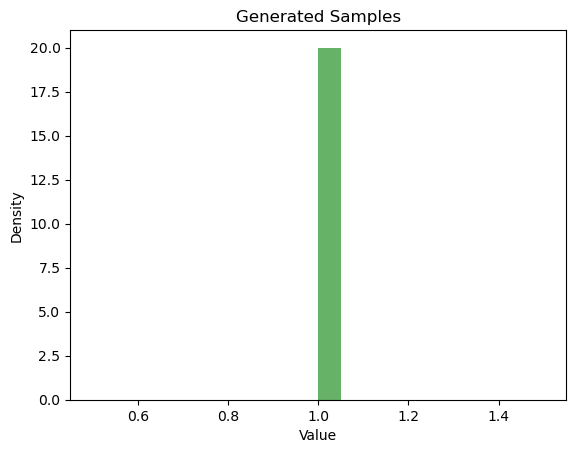

In [11]:
import random
import math
import matplotlib.pyplot as plt


# Simple Scoring Network
class SimpleMLP:
    def __init__(self, input_dim, hidden_dim):
        """
        A simple multi-layer perceptron with 1 hidden layer.
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.w1 = [[random.uniform(-1, 1) for _ in range(hidden_dim)] for _ in range(input_dim)]
        self.b1 = [random.uniform(-1, 1) for _ in range(hidden_dim)]
        self.w2 = [random.uniform(-1, 1) for _ in range(hidden_dim)]
        self.b2 = random.uniform(-1, 1)

    def forward(self, x):
        """
        Forward pass of the MLP.
        """
        # Hidden layer
        z1 = [sum([x[i] * self.w1[i][j] for i in range(self.input_dim)]) + self.b1[j] for j in range(self.hidden_dim)]
        a1 = [math.tanh(z) for z in z1]

        # Output layer
        z2 = sum([a1[j] * self.w2[j] for j in range(self.hidden_dim)]) + self.b2
        return z2

    def update_weights(self, grad_w1, grad_b1, grad_w2, grad_b2, lr):
        """
        Update weights and biases using gradients.
        """
        # Update weights and biases of the first layer
        for i in range(self.input_dim):
            for j in range(self.hidden_dim):
                self.w1[i][j] -= lr * grad_w1[i][j]

        for j in range(self.hidden_dim):
            self.b1[j] -= lr * grad_b1[j]

        # Update weights and biases of the second layer
        for j in range(self.hidden_dim):
            self.w2[j] -= lr * grad_w2[j]
        self.b2 -= lr * grad_b2


# Score Matching Class
class ScoreMatching:
    def __init__(self, snet, alpha, sigma, eta, D, T):
        """
        Score matching implementation without libraries.
        """
        self.snet = snet
        self.alpha = alpha
        self.sigma = sigma
        self.eta = eta
        self.D = D
        self.T = T

    def sample_base(self):
        """
        Uniformly sample from [-1, 1]^D.
        """
        return [random.uniform(-1, 1) for _ in range(self.D)]

    def langevin_dynamics(self, x):
        """
        Perform Langevin dynamics for T steps.
        """
        for _ in range(self.T):
            s_pred = self.snet.forward(x)
            noise = [random.gauss(0, 1) for _ in x]
            x = [x[i] + self.alpha * s_pred + self.eta * noise[i] for i in range(len(x))]
        return x

    def compute_loss_and_gradients(self, x):
        """
        Compute the Score Matching loss and gradients.
        """
        epsilon = [random.gauss(0, 1) for _ in x]
        noisy_x = [x[i] + self.sigma * epsilon[i] for i in range(len(x))]
        s_pred = self.snet.forward(noisy_x)

        # Compute the loss
        loss = (1 / (2 * self.sigma)) * sum([(s_pred + epsilon[i]) ** 2 for i in range(len(x))])

        # Gradients (only scalar outputs implemented)
        grad_w1 = [[2 * (s_pred + epsilon[0]) * noisy_x[i] for j in range(self.snet.hidden_dim)] for i in range(self.D)]
        grad_b1 = [2 * (s_pred + epsilon[0]) for _ in range(self.snet.hidden_dim)]
        grad_w2 = [2 * (s_pred + epsilon[0]) for _ in range(self.snet.hidden_dim)]
        grad_b2 = 2 * (s_pred + epsilon[0])

        return loss, grad_w1, grad_b1, grad_w2, grad_b2

    def train(self, num_epochs, batch_size, lr):
        """
        Train the score model.
        """
        for epoch in range(num_epochs):
            total_loss = 0
            for _ in range(batch_size):
                x = self.sample_base()
                loss, grad_w1, grad_b1, grad_w2, grad_b2 = self.compute_loss_and_gradients(x)
                self.snet.update_weights(grad_w1, grad_b1, grad_w2, grad_b2, lr)
                total_loss += loss

            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / batch_size:.4f}")

    def generate_samples(self, num_samples):
        """
        Generate samples using the learned score model.
        """
        samples = []
        for _ in range(num_samples):
            x = self.sample_base()
            x = self.langevin_dynamics(x)
            x = [math.tanh(val) for val in x]  # Map to range [-1, 1]
            samples.append(x[0])  # For 1D case
        return samples


# Main
if __name__ == "__main__":
    # Hyperparameters
    input_dim = 1
    hidden_dim = 10
    alpha = 0.1
    sigma = 0.1
    eta = 0.05
    T = 100
    num_epochs = 20
    batch_size = 64
    lr = 1e-3

    # Initialize network and model
    snet = SimpleMLP(input_dim, hidden_dim)
    score_matching = ScoreMatching(snet, alpha, sigma, eta, D=input_dim, T=T)

    # Train the model
    score_matching.train(num_epochs, batch_size, lr)

    # Generate samples
    generated_samples = score_matching.generate_samples(num_samples=100)

    # Plot generated samples
    plt.hist(generated_samples, bins=20, density=True, alpha=0.6, color='g')
    plt.title("Generated Samples")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()


## Score Matching: Improvements and Applications

## What Can We Do with Score Matching?

### Improving Score Matching
While score matching provides reasonable generations with simple implementations, several challenges need addressing:

#### Issues with Score Matching
1. **Low-Density Regions**  
   - In regions with sparse data, score estimation can be unreliable.  
   - Refer to Fig. 9.2a: the dark areas, which represent low-density regions, show poorly estimated score functions.

2. **Badly Trained Score Models**  
   - Poorly trained models can lead to suboptimal results in Langevin dynamics, as seen in Fig.3b.

3. **Slow Mixing**  
   - If the modes of the real data distribution are far apart, Langevin dynamics may require many steps to traverse these regions.

#### Methods to Address These Issues
1. **Sequence of Variances**  
   - Use a series of variances instead of a single value and apply annealed Langevin dynamics. Refer to [10] and [11] for detailed methods and tricks.

2. **Sliced Score Matching**  
   - Inspired by the sliced Wasserstein distance [13], the score function and model are projected onto random directions.  
   - The sliced score matching objective simplifies computation to vector multiplication and relates to Hutchinson’s trace estimator.

---

### Extensions of Score Matching

#### Applications in Energy-Based Models  
- **Learning Boltzmann Machines**  
   Score matching has been successfully applied in energy-based models, including Boltzmann machines [14, 15].

- **Other Energy-Based Models**  
   Extensions for energy-based models are discussed in [16].

#### Distributions over Discrete Random Variables  
- Score matching can adapt to discrete random variables by redefining scores for probability mass functions [17].

#### Beyond Images  
- **Modeling Point Clouds**  
   Score matching has been extended for processing point clouds, leveraging specialized score models [18].


### Visualizations
Below, we outline some potential visualizations to accompany the theoretical content.

- **Low-Density Regions:** Illustrate Fig.2a to highlight poor score estimation in sparse regions.
- **Bad Generations:** Display Fig.3b for examples of poorly generated samples.
- **Point Cloud Application:** Visualize point clouds modeled using score matching.
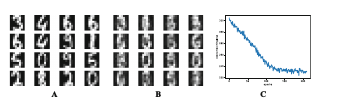

\begin{equation}
\text{Sliced Score Matching Loss: } 
L(\theta) = \mathbb{E}_{\mathbf{v} \sim \mathcal{N}(0, I)} \left[ \|\mathbf{v}^\top (\nabla_\mathbf{x} \log p_\theta(\mathbf{x}) - \mathbf{s}_\theta(\mathbf{x}))\|^2 \right]
\end{equation}
